# 05_LargeScale_Maps
Relation to large-scale patterns of atm. forcing

In [5]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator


import matplotlib.dates as mdates


from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic


sys.path.append('../')
import functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import constants

In [6]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [9]:
# grids = {}

# # ERA5
# #-----
# # era_lat_range = slice(74,68)
# # era_lon_range = slice(-165,-125)

# era_lat_range = slice(90,65)
# era_lon_range = slice(-180,180)
# ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
# ds.close()
# ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
# longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

# grids['era'] = {}
# grids['era']['lat'] = era_map['all']['lat']#latgrid
# grids['era']['lon'] = era_map['all']['lon']#longrid


# # PPD drift
# #----------
# drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
# drift['lon'][drift['lon']>180]-=360
# grids['ppd'] = {}
# grids['ppd']['lat'] = drift['lat']
# grids['ppd']['lon'] = drift['lon']
# grids['ppd']['xx'] = drift['xx']
# grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                
                if lon > -160:
                    grids[key]['region'][ii,jj] = True
                

era


KeyError: 'lon'

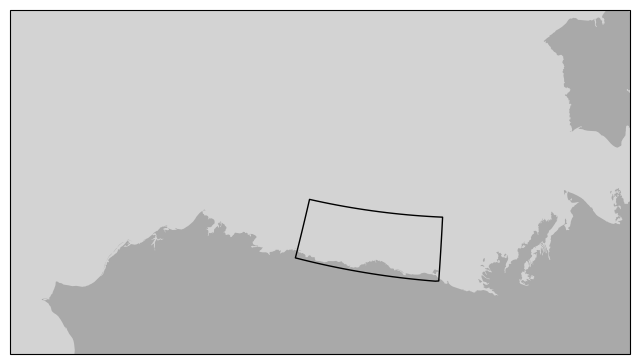

In [11]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())


In [12]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M4.nc')
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


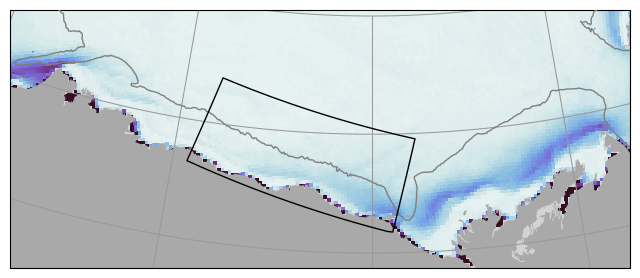

In [13]:
fig, ax = fn.makemap(view='wide', contours = [-100])

ax.pcolormesh(ds.xx, ds.yy, ma.masked_where(np.isnan(ds.sic10), ds.sic70), 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=sic['proj'])
ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [7]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

## Identify continuous polynya sequences

In [14]:
df = pd.read_csv('../data/compiled_stats.csv')

# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]



In [42]:

#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])

event_dates = {}
event_sizes = {}

for dict_, cat_ in zip([event_dates, event_sizes], ['time', 'extent']):
    
    dict_['all'] = DF[cat_][(DF.extent>0)].values
    dict_['b1'] = DF[cat_][(DF.day_before_event==-1)].values
    dict_['a1'] = DF[cat_][(DF.day_after_event==1)].values
    dict_['comp'] = DF[cat_][DF.extent==0].values
#     dict_['q1'] = DF[cat_][(DF.extent <= 155)&(DF.extent > 0)].values
#     dict_['q2'] = DF[cat_][(DF.extent <= 545)&(DF.extent > 155)].values
#     dict_['q3'] = DF[cat_][(DF.extent <= 1715)&(DF.extent > 545)].values
#     dict_['q4'] = DF[cat_][DF.extent>1715].values
    # event_dates['peak'] = DF['time'][DF['peak_day']&(DF['event_day']!=1)].values
    
    for day in [1,2,3,4,5,6,7]:
        
        cond = ((DF.event_day==day)&(shoulder==False)) & (DF.missing_sic==False)
        
        dict_[f'd{day}'] = DF[cat_][cond].values
        
        print(day, np.sum(cond))
        
    cond = ((DF.event_day>=8)&(shoulder==False)) & (DF.missing_sic==False)
    dict_[f'd>7'] = DF[cat_][cond].values
    print(8, np.sum(cond))


# for dict_, cat_ in zip([event_dates, event_sizes], ['time', 'extent']):
    
#     dict_['all'] = DF[cat_][((DF.extent>0)) & ((DF.year > 2016) & (DF.year < 2019))].values
#     dict_['comp'] = DF[cat_][((DF.extent==0)) & ((DF.year > 2016) & (DF.year < 2019))].values




#     dict_['peak'] = DF[cat_][DF['peak_day']].values

# for mm in [12,1,2,3,4]:
#     NAME = calendar.month_name[mm][:3]
#     event_dates[NAME] = DF['time'][(DF.month ==mm)&(DF.extent > 0)].values
#     event_sizes[NAME] = DF['extent'][(DF.month ==mm)&(DF.extent > 0)].values

1 151
2 100
3 70
4 46
5 29
6 20
7 16
8 71
1 151
2 100
3 70
4 46
5 29
6 20
7 16
8 71


In [8]:
len(event_dates['comp'])

2788

In [9]:
len(event_dates['all'])

539

In [37]:
302/151

2.0

In [28]:
event_durations = []
exclude = (DF.season_end_flag == True) + (DF.season_start_flag == True)
for ss in list(set(DF.sequence[(DF.sequence!=-999)&(exclude==False)])):
    event_durations.append(DF.event_day[DF.sequence == ss].values.max())
event_durations = np.array(event_durations)
    
print(np.nanpercentile(event_durations, 0))
print(np.nanpercentile(event_durations, 25))
print(np.nanpercentile(event_durations, 50))
print(np.nanpercentile(event_durations, 75))
print(np.nanpercentile(event_durations, 100))

1.0
1.0
2.0
4.0
25.0


In [158]:
np.sum(event_durations>7)/len(event_durations)

0.125

In [26]:
event_durations

array([ 1, 15,  1,  5,  2,  1,  3,  5])

In [21]:
print(np.nanpercentile(event_sizes['all'], 0))
print(np.nanpercentile(event_sizes['all'], 25))
print(np.nanpercentile(event_sizes['all'], 50))
print(np.nanpercentile(event_sizes['all'], 75))
print(np.nanpercentile(event_sizes['all'], 100))

38.9534950891628
156.02098082101196
545.6502435487383
1696.4126676445198
24153.382680013918


In [12]:
np.sum((event_sizes['all']>545)/(np.sum(event_sizes['all']>0)))

0.5083487940630798

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93799/3018492605.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Polynya extent ($\mathrm{km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_93799/3018492605.py:45: SyntaxWarning: invalid escape sequence '\m'
  ax.text(30, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS, clip_on=False)
/var/

Text(26500, 12.5, '$\\mathrm{Q_{4}}$')

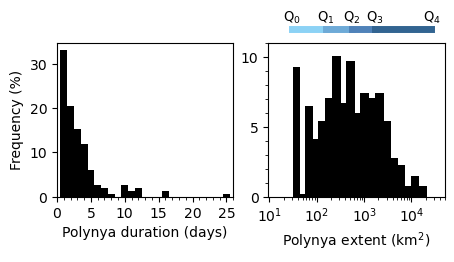

In [31]:
fig, axs = plt.subplots(1,2,figsize=(5,2))

bins = np.arange(0.5,30,1)
x = event_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*(h['counts']/np.sum(h['counts'])), align='center', width = np.diff(bins), 
       color='k')
# ax.set_xticks([1,5,10,15,20])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Polynya duration (days)')
ax.set_xlim(0,26)
ax.set_ylabel('Frequency (%)')

bins = np.logspace(1.5, 12, num=70)
x = event_sizes['all']
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[1]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='k')
ax.set_xscale('log')
ax.set_xlim(0,50000)
# ax.set_xticks([10,100,1000,10000])

c1 = [140/255,210/255,245/255]
c2 = [110/255,170/255,215/255]
c3 = [80/255,130/255,185/255]
c4 = [50/255,100/255,145/255]

YY = 12
ax.plot([30,155],[YY,YY], c=c1, lw=5, clip_on=False)
ax.plot([155,545],[YY,YY], c=c2, lw=5, clip_on=False)
ax.plot([545,1700],[YY,YY], c=c3, lw=5, clip_on=False)
ax.plot([1700,26500],[YY,YY], c=c4, lw=5, clip_on=False)
ax.set_ylim(0,11)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# plt.axvline(39, c='k', ls='dashed')
# plt.axvline(2*39, c='k', ls='dashed')
ax.set_xlabel('Polynya extent ($\mathrm{km^2}$)')

bot2 = YY+0.5
FS = plt.rcParams['font.size'] -0.5
ax.text(30, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS, clip_on=False)
ax.text(155, bot2, '$\mathrm{Q_{1}}$', ha='center', size=FS, clip_on=False)
ax.text(545, bot2, '$\mathrm{Q_{2}}$', ha='center', size=FS, clip_on=False)
ax.text(1700, bot2, '$\mathrm{Q_{3}}$', ha='center', size=FS, clip_on=False)
ax.text(26500, bot2, '$\mathrm{Q_{4}}$', ha='center', size=FS, clip_on=False)

# fig.savefig('../figures/results/poly_dist.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [32]:
RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


out = unisic.calc_meansic_openfreq([datetime(2024,1,1), datetime(2024,1,2)], crop=crop, 
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

### Grab SIC maps

In [33]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

open_thresh=10

map_sic = {}

for key in event_dates.keys():

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(event_dates[key]), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


all
b1
a1
comp
d1
d2
d3
d4
d5
d6
d7
d>7


### Grab drift maps

In [457]:
drift_map = {}

for key in event_dates.keys():
    print(key)
    drift_map[key] = fn.drift_map_over_time(event_dates[key], map_proj)

all
b1
a1
comp
d1
d2
d3
d4
d5
d6
d7
d>=8


### Open ERA maps

In [458]:
era_map = {}

for key in event_dates.keys():
    
    print(key)
    
    era_map[key] = fn.wind_map_over_time(event_dates[key], map_proj, 
                                         era_lat = slice(77, 68), era_lon = slice(-160,-120))

all
missing 2024-12-03 00:00:00
missing 2024-12-04 00:00:00
missing 2024-12-05 00:00:00
missing 2024-12-09 00:00:00
missing 2024-12-10 00:00:00
missing 2024-12-11 00:00:00
missing 2024-12-12 00:00:00
missing 2024-12-13 00:00:00
missing 2024-12-14 00:00:00
missing 2024-12-16 00:00:00
missing 2024-12-17 00:00:00
missing 2024-12-18 00:00:00
missing 2024-12-19 00:00:00
missing 2025-01-13 00:00:00
missing 2025-02-15 00:00:00
missing 2025-03-06 00:00:00
missing 2025-03-07 00:00:00
missing 2025-03-08 00:00:00
missing 2025-03-09 00:00:00
missing 2025-03-10 00:00:00
missing 2025-03-11 00:00:00
missing 2025-03-12 00:00:00
missing 2025-03-13 00:00:00
missing 2025-03-14 00:00:00
missing 2025-03-15 00:00:00
missing 2025-03-20 00:00:00
missing 2025-03-21 00:00:00
missing 2025-03-22 00:00:00
missing 2025-03-23 00:00:00
missing 2025-03-24 00:00:00
missing 2025-04-14 00:00:00
b1
missing 2024-12-02 00:00:00
missing 2024-12-08 00:00:00
missing 2024-12-15 00:00:00
missing 2025-01-12 00:00:00
missing 2025-

In [19]:

M = {}
for mooring in ['M1', 'M2', 'M3', 'M4']:  
    M[mooring] = {}
    
    open_years = '2017_2018'
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f"{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc") as ds:
        M[mooring]['lat'] = ds.lat
        M[mooring]['lon'] = ds.lon

        
# # create false M0 mooring along shelf current
# M['M0'] = {}
# shelf_angle = 145
# # shelf_angle = 165
# shelf_az = 90-shelf_angle
# M['M0']['lon'], M['M0']['lat'], backaz = g.fwd(M['M1']['lon'], M['M1']['lat'], shelf_az, 80000)

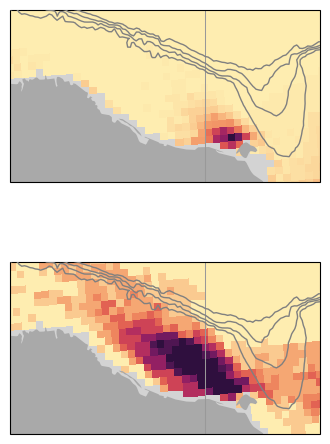

In [35]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(4,6), panels=(2,1))

for ax in axs:
    line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
    for lat in [69,71,73]:
        ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
    for lon in [-160,-150,-140,-130]:
        ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


    

key = 'd1'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

key = 'd6'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])


NameError: name 'reg_poly' is not defined

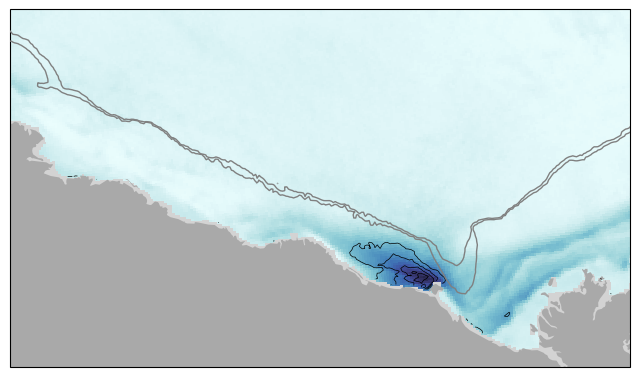

In [14]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-200,-100])


key = 'all'
# key2='comp'

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.haline_r, transform=dsic['proj'])

ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=10, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])

ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
           levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=0.5, transform=dsic['proj'])


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    





# ax.quiver(drift_map_moor[key]['X_scaled'], drift_map_moor[key]['Y_scaled'], 
#           eS1, nS1, 
#           angles='xy', scale_units='xy', 
#           scale=1, width=0.0035, pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude

# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)


# u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s2 = np.nanmean(np.sqrt(drift_map[key2]['u']**2+drift_map[key2]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude
# vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# speed_diff = s1-s2
# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], (vec_diff)/1000, 
#               vmin=0, vmax=13, cmap=cmocean.cm.haline, transform=drift_map[key]['proj'], zorder=0)

    
    
# uw1 = np.nanmean(era_map[key]['u10'], axis=0)
# vw1 = np.nanmean(era_map[key]['v10'], axis=0)
# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)


# uw2 = np.nanmean(era_map[key2]['u10'], axis=0)
# vw2 = np.nanmean(era_map[key2]['v10'], axis=0)
# sw2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

# vec_diff = np.sqrt((uw1-uw2)**2+(vw1-vw2)**2)   

# # speed_diff = np.sqrt((uw1)**2+(vw1)**2) - np.sqrt((uw2)**2+(vw2)**2)   

# speed_diff = sw1-sw2 


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100, 
#               vmin=1010,vmax=1030,
#               cmap=cmocean.cm.haline_r, transform=ccrs.PlateCarree())

# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['msl'], axis=0)-np.nanmean(era_map[key2]['msl'], axis=0))/100, 
#               vmin=-20,vmax=20,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['vort'], axis=0)), 
#               vmin=-0.001,vmax=0.001,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            sw1-sw2, 
#               vmin=-5,vmax=5,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100,
#            levels=np.arange(980,1060,1), colors=['k'],
#            transform=ccrs.PlateCarree(), zorder=100)

    
# ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, levels=[3,4,5,6,7,8],
#               vmin=0, vmax=8, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)

# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], 
#               (np.nanmean(era_map[key]['msl'],axis=0))/100, 
#               vmin=1010, vmax=1030, levels=np.arange(1000,1044,1),
#             cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)


# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw2)[::sp1,::sp2], 
#                                      (vw2)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 100, width = 0.0025,color='gray',
#           transform=ccrs.PlateCarree())

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
#                                      (vw1)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025,
#           transform=ccrs.PlateCarree())



# uwt = np.full(uw1.shape, 10*np.cos(165*np.pi/180))
# vwt = np.full(uw1.shape, 10*np.sin(165*np.pi/180))

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uwt)[::sp1,::sp2], 
#                                      (vwt)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025, color='red',
#           transform=ccrs.PlateCarree())


# ax.scatter(m1.attrs['lon'], m1.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m2.attrs['lon'], m2.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m3.attrs['lon'], m3.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m4.attrs['lon'], m4.attrs['lat'], transform=ccrs.PlateCarree())

# fig.savefig('../figures/results/comp_map_all_msl.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [136]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'vort', 'lon', 'lat'])

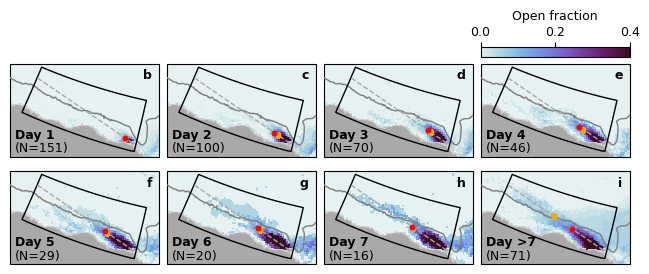

In [86]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,4), figsize=(8,2.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10

tru_dists = np.array([31.41056723,  64.54320495,
                      79.37149842, 101.65035716, 117.79909441, 134.01560083,
                      144.42282603, 131.747859128])

wind_dists = np.array([31.69151215,  47.77875029,
        66.23453892,  83.33545515, 107.88820641, 124.87097074,
       138.03321063, 207.90784043896])


# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in range(1,8)]+[f'd>7'],
                     range(8)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.4, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    C = 'orange'
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c=C, lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='s', c=C,  zorder=100)
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, tru_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c='r', lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='o', c='r',  zorder=100)

   
#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    

plotter.add_colorbar(fig, axs[3], [mesh], cb_placement='top', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.2,0.4], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open fraction', labelpad='auto', 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)



In [62]:

plt.show()

In [450]:
drift_map.keys()

dict_keys(['all', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:46: RuntimeWarning: Mean of empty slice
  sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:47: RuntimeWarning: Mean of empty slice
  s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:48: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:49: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


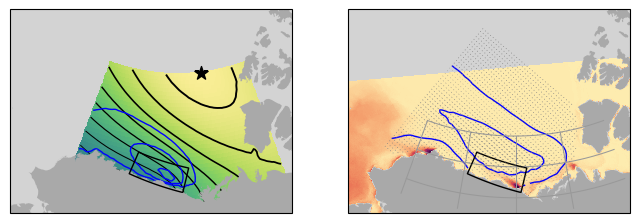

In [854]:
fig, axs = fn.makemap(view='large_view', panels=(1,2), contours = [])

for ax in axs:
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
    
key = 'all'
keyb = 'comp'

ax = axs[0]

LEVELS = np.arange(1001,1040,2)
LW = 2*(LEVELS-LEVELS.min())/(LEVELS.max()-LEVELS.min())
ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1028,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
ax.contour(era_map[key]['lon'], era_map[key]['lat'],sw1,
            levels=[8,9,10], colors=['b'],  linewidths = 1,
           transform=ccrs.PlateCarree(), zorder=0)


max_msl = np.nanmax(np.nanmean(era_map[key]['msl'], axis=0))

ax.scatter(era_map[key]['lon'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)], 
           era_map[key]['lat'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)],
           transform=ccrs.PlateCarree(), zorder=100, marker='*', c='k', s=100)


ax = axs[1]

sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude

ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
          u1, v1, 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

ax.contour(drift_map[key]['xx'], drift_map[key]['yy'], s1, 
            levels=[10,15,20], colors=['b'],  linewidths = 1,
           transform=drift_map[key]['proj'], zorder=0)


ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean']-map_sic['comp']['sic_mean'], 
#               vmin=-50, vmax=50, cmap=cmocean.cm.balance, transform=dsic['proj'], zorder=-1000)

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.balance, 50, which='max', N=None)
# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=10, vmax=100, cmap=newcmap, transform=dsic['proj'], zorder=-1000)


# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], s1,
#               vmin=5,vmax=20, cmap=cmocean.cm.speed, transform=drift_map[key]['proj'], zorder=-100)

# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'], sw1, 
#               vmin=0,vmax=10, cmap=cmocean.cm.haline, zorder=-100, transform=ccrs.PlateCarree())


# ax.coastlines(zorder=101)

fig.savefig('../figures/results/comp_map_all.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [574]:
import matplotlib.path as mpath

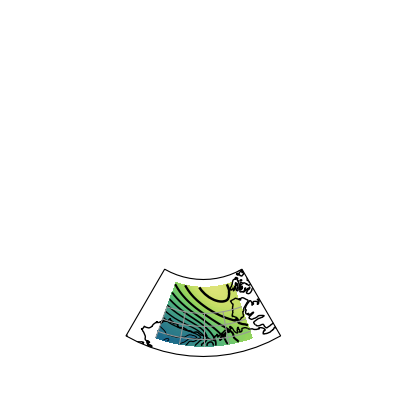

In [828]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(5,5))
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 72)
theta = np.arange(0, 361, 5) * np.pi/180

IND = 30
# circle 1
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
vals = (verts * radius) + center

# circle2
vals2 = np.copy(vals[IND:-IND])
vals2[0] = center
vals2[-1] = center

# circle3
center, radius = [0.5, 0.5], 0.2
vertsn = np.vstack([np.sin(theta), np.cos(theta)]).T
valsn = (vertsn * radius) + center

# stitch together
VALS = np.copy(vals[IND:-IND])
VALS = np.concatenate((VALS, valsn[IND:-IND,:][::-1]), axis=0)


circle = mpath.Path(VALS)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1030,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# plt.subplots_adjust(top=0.1, bottom=-0.2, left=-0.3, right=1.3)

fig.savefig('/Users/mackenziejewell/Desktop/testimg.png', dpi=330, bbox_inches='tight', pad_inches=0)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:36: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:37: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


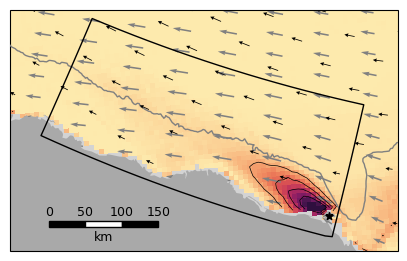

In [708]:
sys.path.append('../')
import functions as fn
fig, ax = fn.makemap(view='wider_zoom2', contours = [-100,], figsize=(5,5))

geomap.scalebar(ax, loc=(0.1, 0.1), steps=[50,100,150],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

from pyproj import Geod
g = Geod(ellps='WGS84')
startlon, startlat = -139.1, 69.6
ax.scatter(startlon, startlat, zorder=100, s= 30, marker='*', c='k', transform=ccrs.PlateCarree())

ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

# around_HI = {}
# around_HI['lon'] = []
# around_HI['lat'] = []
# for dist in [50]:
#     for az in np.linspace(-90,140,30):
#         endlon, endlat, backaz = g.fwd(startlon, startlat, az, dist*1000)
#         around_HI['lon'].append(endlon)
#         around_HI['lat'].append(endlat)
        
# ax.plot(around_HI['lon'], around_HI['lat'], c='k', 
#         ls='dashed', transform=ccrs.PlateCarree(), zorder=1000)


key = 'all'
ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])
ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
            levels=[0.1,0.2,0.3,0.4], colors=['k'], linewidths=0.5, transform=dsic['proj'])
    

u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
sp = 2
ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], 
          u1[::sp,::sp], v1[::sp,::sp], angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.002, headwidth=5,  color='k', pivot='tail', zorder=100)


    
uw1 = np.nanmean(era_map[key]['u10'], axis=0)
vw1 = np.nanmean(era_map[key]['v10'], axis=0)
sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

sp1 = 1
sp2 = 7
ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
         *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
                                     (vw1)[::sp1,::sp2], 
                                     era_map[key]['lat'][::sp1,::sp2]), 
          scale = 180, width = 0.004,color='gray',
          transform=ccrs.PlateCarree())

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

In [702]:
era_map.keys()

dict_keys(['all', 'b1', 'a1', 'comp', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

In [289]:
dates = pd.to_datetime(DF.time[(DF['event_day']==5)&(shoulder==False)].values)

SIC = unisic.open_local_file(dates[21], res = '6250', hem ='n', 
                    main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                    crop = crop,
                     coordinates = False, area = False,
                     include_units = False, quiet = True,)

In [291]:
dates[21]

Timestamp('2022-03-02 00:00:00')

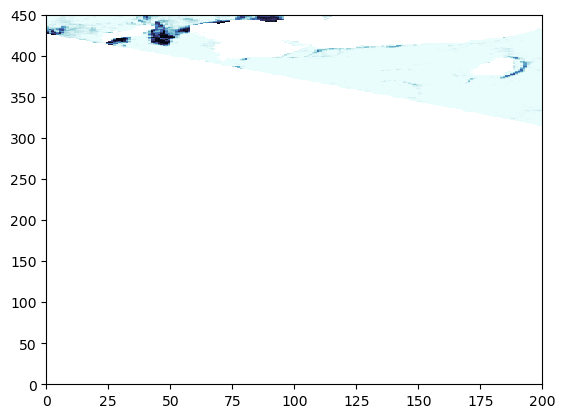

In [290]:
plt.pcolormesh(SIC['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)

In [527]:
np.sum(flag_dates == False)

87

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2019-12-12 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2024-01-14 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2022-02-28 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2025-03-11 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2016-04-12 00:00:00


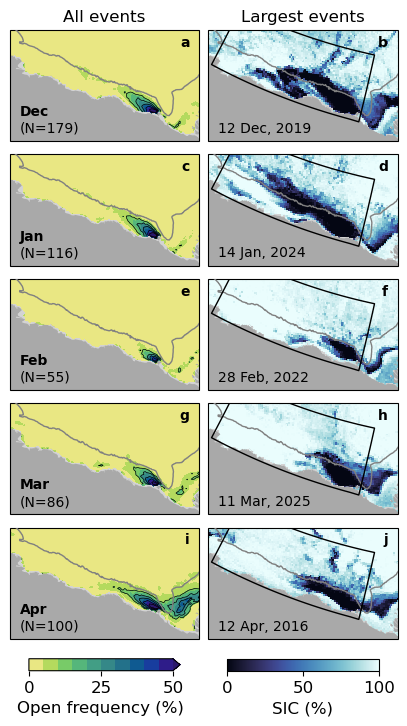

In [569]:
fig, axs = fn.makemap(view='wider_zoom', contours = [-100], 
                      panels=(5,2), figsize=(5,8))
plt.subplots_adjust(hspace=0.05, wspace=0.05)



for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
                     [0,2,4,6,8], [1,3,5,7,9]):

    
    axs[n].text(0.95,0.95,f'{chr(97+n)}', weight='bold', 
                ha='right', va='top', transform=axs[n].transAxes)
    axs[N].text(0.95,0.95,f'{chr(97+N)}', weight='bold', 
                ha='right', va='top', transform=axs[N].transAxes)

    
    
    ax = axs[n]
    
    ax.text(0.05,0.2,key, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.text(0.05,0.05,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes)
    
#     ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    
#     mesh1 = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 
#                           100*map_sic[key]['open_freq'], 
#                   vmin=0, vmax=50, cmap=cmocean.cm.haline_r, transform=dsic['proj'])
    
    mesh1 = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'],  100*map_sic[key]['open_freq'], 
                  levels=np.arange(0,51,5), vmin=0, vmax=50, extend='max',  cmap=cmocean.cm.haline_r, 
                linewidths=0.5,  transform=dsic['proj'])
    

#     ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#                   vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
               ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
                  levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])



#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
#            ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
#               levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])




    
    
    
    
    # SPECIFIC EVENTS
    #------------------------------
    # flag dates in three years during freezeup/breakup
    current_dates = pd.to_datetime(event_dates[key])
    flag_dates = np.full(len(current_dates), False)
    flag_dates[(current_dates >= datetime(2007,12,1)) & (current_dates <= datetime(2007,12,15))] = True
    flag_dates[(current_dates >= datetime(2016,4,19)) & (current_dates <= datetime(2016,4,30))] = True
    flag_dates[(current_dates >= datetime(2018,4,30)) & (current_dates <= datetime(2018,4,30))] = True
    
    
    spec_ind = np.where(event_sizes[key] == np.max(event_sizes[key][flag_dates==False]))[0][0]
    spec_date = current_dates[spec_ind]
    print(spec_date)
    spec_sic = unisic.open_local_file(spec_date, res=RES, crop=crop, 
                                      coordinates=False, area=False, include_units=False, quiet=True)
    ax = axs[N]
    ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    mesh2 = ax.pcolormesh(spec_sic['xx'], spec_sic['yy'], spec_sic['sic'], 
                      vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=spec_sic['proj'])

    
    ax.text(0.05,0.05,spec_date.strftime('%d %b, %Y'), 
            ha='left', va='bottom', transform=ax.transAxes)

    
    

plotter.add_colorbar(fig, axs[8], [mesh1], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks=[0,25,50], 
             cb_ticklabels='auto', cb_extend='neither', cb_label='Open frequency (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

plotter.add_colorbar(fig, axs[9], [mesh2], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

axs[0].set_title('All events')
axs[1].set_title('Largest events')

fig.savefig('../figures/results/monthly_maps_cf.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [558]:
n

0

In [531]:
np.sum(np.isnan(map_sic[key]['open_freq']))

168819

In [532]:
np.sum(np.isnan(map_sic[key]['sic_mean']))



168819

In [524]:
help(plotter.add_colorbar)

Help on function add_colorbar in module plot_simply.general:

add_colorbar(fig, ax, colorbar_input, cb_placement='left', cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither', cb_label=' ', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
    Function for plotting colorbar along edge of figure axis.

    INPUT:
    - fig: figure to which colorbar will be added
    - ax: figure axis to which colorbar will be added
    - colorbar_input: either specify [matplotlib.collections.QuadMesh], pmatplotlib.cm.ScalarMappable] (from pcolormesh plot output),
                        [cartopy.mpl.contour.GeoContourSet] (from countourf output),
                      or specify [cmap, norm]
                       where cmap is matplotlib cmap (e.g. 'RdBu')
                       where norm is matplotlib.colors normlalization ins

In [520]:
spec_date.strftime('%d %b, %Y')

'12 Apr, 2016'

In [ ]:
uwt = np.fulle
vwt = np.nanmean(era_map[key]['v10'], axis=0)

In [81]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'lon', 'lat'])

# Reference vectors

In [1615]:
upslope = {}

upslope['m1'] = {}
upslope['m1']['angle'] = 145 * units('degree')

upslope['m2'] = {}
upslope['m2']['angle'] = -150 * units('degree')

upslope['m3'] = {}
upslope['m3']['angle'] = -115 * units('degree')

upslope['m4'] = {}
upslope['m4']['angle'] = -90 * units('degree')


for m, M in zip([m1, m2, m3, m4], upslope.keys()):
    
    mag = 0.1
    cu = mag*np.cos(upslope[M]['angle'].to('rad'))
    cv = mag*np.sin(upslope[M]['angle'].to('rad'))

    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    tail, tip, vec = vectors.project_vectors(map_proj, m.attrs['lon'], m.attrs['lat'], 
                    eastward=cu*units('m/s'), 
                    northward=cv*units('m/s'), final_units='m/day')
    
    upslope[M]['tail'] = tail
    upslope[M]['tip'] = tip
    upslope[M]['vec'] = vec


# find 2016-2018 dates

In [59]:
all_spec_dates = np.array([], dtype=np.datetime64)

all_spec_dates = pd.to_datetime(DF.time[ (DF.extent > 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
all_other_dates = pd.to_datetime(DF.time[ (DF.extent == 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
# for ss in all_seqs.keys():
#     if (all_seqs[ss][0] >= datetime(2016,12,1)) & (all_seqs[ss][-1] <= datetime(2018,4,30)):
#         all_spec_dates = np.append(all_spec_dates, all_seqs[ss])
# print(all_spec_dates[0], all_spec_dates[-1])

# all_other_dates = np.array([], dtype=np.datetime64)
# for date in pd.date_range(all_spec_dates[0], all_spec_dates[-1]):
#     if date not in all_spec_dates:
#         if date.month not in [5,6,7,8,9,10,11]:
#             all_other_dates = np.append(all_other_dates,date)

In [60]:
spec_y1 = all_spec_dates[all_spec_dates < datetime(2017,11,1)]
spec_y2 = all_spec_dates[all_spec_dates > datetime(2017,11,1)]

other_y1 = all_other_dates[all_other_dates < datetime(2017,11,1)]
other_y2 = all_other_dates[all_other_dates > datetime(2017,11,1)]



## Calc mean flows

In [65]:
mvec = {}
mvec['m1'] = {}
mvec['m1']['depth_range'] = (-50,0)

mvec['m2'] = {}
mvec['m2']['depth_range'] = (-150,-50)

mvec['m3'] = {}
mvec['m3']['depth_range'] = (-150,-50)

mvec['m4'] = {}
mvec['m4']['depth_range'] = (-150,-50)


groups = ['open', 'comp']

for M in mvec.keys():
    
    for group in groups:
        
        mvec[M][group] = {}

        mvec[M][group]['tip_x'] = np.array([])
        mvec[M][group]['tip_y'] = np.array([])

        mvec[M][group]['vec_x'] = np.array([])
        mvec[M][group]['vec_y'] = np.array([])
        
        mvec[M][group]['itip_x'] = np.array([])
        mvec[M][group]['itip_y'] = np.array([])

        mvec[M][group]['ivec_x'] = np.array([])
        mvec[M][group]['ivec_y'] = np.array([])



In [66]:

for spec_y_dates, other_y_dates, open_years in zip([spec_y1, spec_y2], 
                                                   [other_y1, other_y2],
                                                   ['2016_2017', '2017_2018']):
    
    # open_years = '2017_2018'
    m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
    m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_ocean_currents_{open_years}.nc')
    m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_ocean_currents_{open_years}.nc')
    m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_ocean_currents_{open_years}.nc')

    m1i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc')
    m2i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_{open_years}.nc')
    m3i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_{open_years}.nc')
    m4i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_{open_years}.nc')

    m1t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
    m2t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
    m3t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
    m4t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')

    print(open_years)
    
    for m, mi, M in zip([m1, m2, m3, m4], [m1i, m2i, m3i, m4i], mvec.keys()):
        
        print(M)
        
        for group, dates in zip(['open', 'comp'], [spec_y_dates, other_y_dates]):
            
            cdata = mvec[M][group]

            tails, tips, vecs = grab_vector_range(m, dates, depth_range = mvec[M]['depth_range'], daily_means=True)

            # grab tips
            cdata['tip_x'] = np.append(cdata['tip_x'], np.array([tip[0] for tip in tips]))
            cdata['tip_y'] = np.append(cdata['tip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['tail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['tail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['vec_x'] = np.append(cdata['vec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['vec_y'] = np.append(cdata['vec_y'], np.array([vec[1].magnitude for vec in vecs]))

            
            
            # ICE VELOCITIES
            tails, tips, vecs = grab_icevector_range(mi, dates)

            # grab tips
            cdata['itip_x'] = np.append(cdata['itip_x'], np.array([tip[0] for tip in tips]))
            cdata['itip_y'] = np.append(cdata['itip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['itail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['itail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['ivec_x'] = np.append(cdata['ivec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['ivec_y'] = np.append(cdata['ivec_y'], np.array([vec[1].magnitude for vec in vecs]))

    
    
for M in mvec.keys():
    
    for group in ['open', 'comp']:

        cdata = mvec[M][group]
        
        x = cdata['vec_x']
        y = cdata['vec_y']

        cdata['mean_x'] = np.nanmean(cdata['vec_x'])
        cdata['mean_y'] = np.nanmean(cdata['vec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['varell_x'] = varell['xe']
        cdata['varell_y'] = varell['ye']
        
        
        # ice velocities
        #----------------
        x = cdata['ivec_x']
        y = cdata['ivec_y']

        cdata['imean_x'] = np.nanmean(cdata['ivec_x'])
        cdata['imean_y'] = np.nanmean(cdata['ivec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['ivarell_x'] = varell['xe']
        cdata['ivarell_y'] = varell['ye']
    

2016_2017
m1
m2
m3
m4
2017_2018
m1
m2
m3
m4


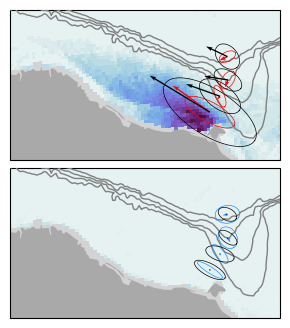

In [78]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(6,4), panels=(2,1))



# for ax in axs:
#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [69,71,73]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-160,-150,-140,-130]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


#     for m in ['M1', 'M2', 'M3', 'M4']: 

#         ax.scatter(M[m]['lon'], M[m]['lat'], transform=ccrs.PlateCarree(), c='k')

    

key = 'all'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

key = 'comp'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])


aw = 0.004

for M in mvec.keys():

    for group, color, ax in zip(['open', 'comp'], ['r', 'dodgerblue'], [axs[0], axs[1]]):

        cdata = mvec[M][group]

        ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=1, color=color, width=1.2*aw, zorder=100)

        ax.plot(cdata['varell_x']+cdata['tail_x'], 
                cdata['varell_y']+cdata['tail_y'], c=color, zorder=100, lw=0.5, alpha=1)

        
        ax.quiver(cdata['itail_x'], cdata['itail_y'], 
                  cdata['imean_x'], cdata['imean_y'], 
                  angles='xy', scale_units='xy', scale=1, color='k', width=1.2*aw, zorder=100)

        ax.plot(cdata['ivarell_x']+cdata['itail_x'], 
                cdata['ivarell_y']+cdata['itail_y'], c='k', zorder=100, lw=0.5, alpha=1)

plt.subplots_adjust(hspace=0.05)

# fig.savefig('../figures/results/canyon_flow_topdown.png', dpi=400, bbox_inches='tight', pad_inches=0)


<IPython.core.display.Javascript object>


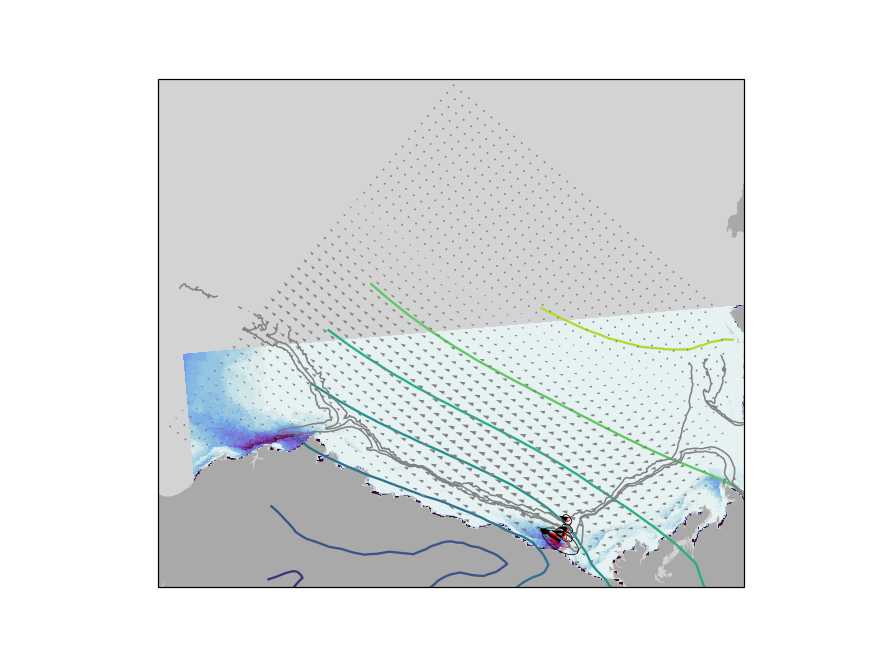

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/1714353791.py:61: RuntimeWarning: Mean of empty slice
  speed1 = np.nanmean(np.sqrt(drift_map_moor[group]['e']**2+drift_map_moor[group]['n']**2), axis=0)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/1714353791.py:62: RuntimeWarning: Mean of empty slice
  e1 = np.nanmean(drift_map_moor[group]['e'], axis=0)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/1714353791.py:63: RuntimeWarning: Mean of empty slice
  n1 = np.nanmean(drift_map_moor[group]['n'], axis=0)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/1714353791.py:64: RuntimeWarning

In [1820]:
fig, ax = fn.makemap(view='very_tall', contours = [-500, -200,-100])

# ax.scatter(tip_xx, tip_yy, s=1)
# ax.quiver(tail_xx, tail_yy, np.nanmean(xp), np.nanmean(yp), 
#           angles='xy', scale_units='xy', scale=1, color='k',width = aw, zorder=100)

for M in upslope.keys():

    ax.quiver(*upslope[M]['tail'], *upslope[M]['vec'], 
              angles='xy', scale_units='xy', scale=1, color='gray',width = aw, zorder=100)

    
    
    
group = 'open'
ax.pcolormesh(map_spec_sic[group]['xx'], map_spec_sic[group]['yy'],
              map_spec_sic[group]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, 
              transform=sic['proj'])

# ax.contour(map_spec_sic[group]['xx'], map_spec_sic[group]['yy'],
#               map_spec_sic[group]['open_freq'], 
#               levels=[0.05,0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=[0.5],
#               transform=sic['proj'])




    
    
group = 'open'
speed1 = np.nanmean(np.sqrt(drift_map_moor[group]['e']**2+drift_map_moor[group]['n']**2), axis=0)
e1 = np.nanmean(drift_map_moor[group]['e'], axis=0)
n1 = np.nanmean(drift_map_moor[group]['n'], axis=0)
u1 = np.nanmean(drift_map_moor[group]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map_moor[group]['v'], axis=0)*units('cm/s').to('m/day').magnitude
eS1 = drift_map_moor[group]['E_scaled']
nS1 = drift_map_moor[group]['N_scaled']

# ax.quiver(drift_map_moor[key]['X_scaled'], drift_map_moor[key]['Y_scaled'], 
#           eS1, nS1, 
#           angles='xy', scale_units='xy', 
#           scale=1, width=0.0035, pivot='tail', zorder=100)


ax.quiver(drift_map_moor[group]['xx'], drift_map_moor[group]['yy'], 
          u1, v1, 
          angles='xy', scale_units='xy', transform=drift_map_moor[group]['proj'],
          scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)


ax.contour(era_map_moor[group]['lon'], era_map_moor[group]['lat'], 
          np.nanmean(era_map_moor[group]['msl'], axis=0)/100, transform=ccrs.PlateCarree())

## Grab pack ice drift during events

In [1783]:
moor_dates = {}
moor_dates['open'] = all_spec_dates
moor_dates['comp'] = all_other_dates

drift_map_moor = {}

for key in moor_dates.keys():
    print(key)
    drift_map_moor[key] = fn.drift_map_over_time(moor_dates[key], map_proj)

In [1813]:
era_map_moor = {}

for key in moor_dates.keys():
    
    print(key)
    
    era_map_moor[key] = fn.wind_map_over_time(moor_dates[key], map_proj, 
                                              era_lat = slice(75, 68), era_lon = slice(-158,-125))

open
comp


In [1778]:
# open data and crop to time range
year = 2018
DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
time_range = slice(datetime(year-1,12,1), datetime(year,4,30,23))
DS = DS.sel(time = time_range)

In [1779]:


SIG_lp = tseries.running_mean(m1t.sig0.mean('depth'), length=24*30, center=True, address_nans=True)
SIG_sfc_lp = tseries.running_mean(m1t.sig0.sel(depth=-16), length=24*30, center=True, address_nans=True)
SIG_sfc_mp = tseries.running_mean(m1t.sig0.sel(depth=-16), length=24, center=False, address_nans=True)
SIG_mp = tseries.running_mean(m1t.sig0.mean('depth'), length=24, center=True, address_nans=True)
dSIG = m1t.sig0.mean('depth')-SIG_lp

dT_mp = tseries.running_mean((m1t.T-m1t.Tf).mean('depth'), length=24, center=True, address_nans=True)

/Users/mackenziejewell/Documents/GitHub/SBSpolynya/notebooks/../../timeseries/adjust.py:162: RuntimeWarning: Mean of empty slice
  running_mean[ii] = np.nanmean(variable[ii-length:ii+1])


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/3064059659.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax= plt.subplots(figsize=(8,3))


<IPython.core.display.Javascript object>


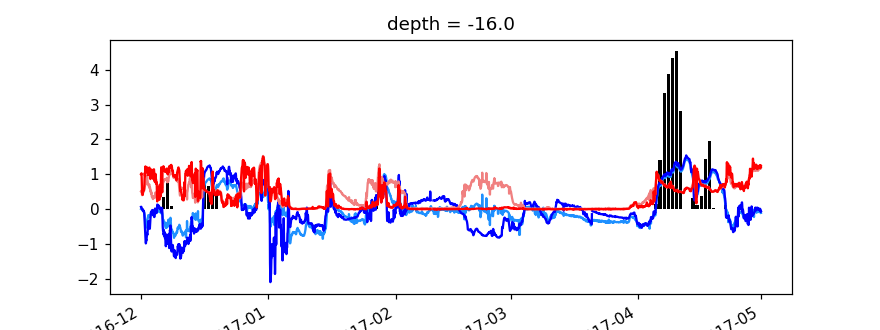

<BarContainer object of 151 artists>

In [1696]:
fig, ax= plt.subplots(figsize=(8,3))
# dSIG.sel(time=slice(datetime(2017,12,1),datetime(2018,4,30,23))).plot()
(m1t.sig0.mean('depth')-SIG_lp).sel(time=time_range).plot(c='dodgerblue')

(m1t.sig0.sel(depth=-16)-SIG_sfc_lp).sel(time=time_range).plot(c='b')

(m1t.T-m1t.Tf).mean('depth').sel(time=time_range).plot(c='lightcoral')
(m1t.T-m1t.Tf).sel(depth=-16).sel(time=time_range).plot(c='r')

plt.bar(DS.time, DS.polynya_extent/1000, color='k',align='edge', zorder=-1)

In [1780]:
ui = m1i.sel(depth=0).u.sel(time=time_range)
vi = m1i.sel(depth=0).v.sel(time=time_range)

speed = np.sqrt(ui**2+vi**2)
esei = vectors.comp_along_theta(ui, vi, 160*units('degree'))

uo = m1.mean('depth').u.sel(time=time_range)
vo = m1.mean('depth').v.sel(time=time_range)
# speed = np.sqrt(ui**2+vi**2)
eseo = vectors.comp_along_theta(uo, vo, 145*units('degree'))

<IPython.core.display.Javascript object>


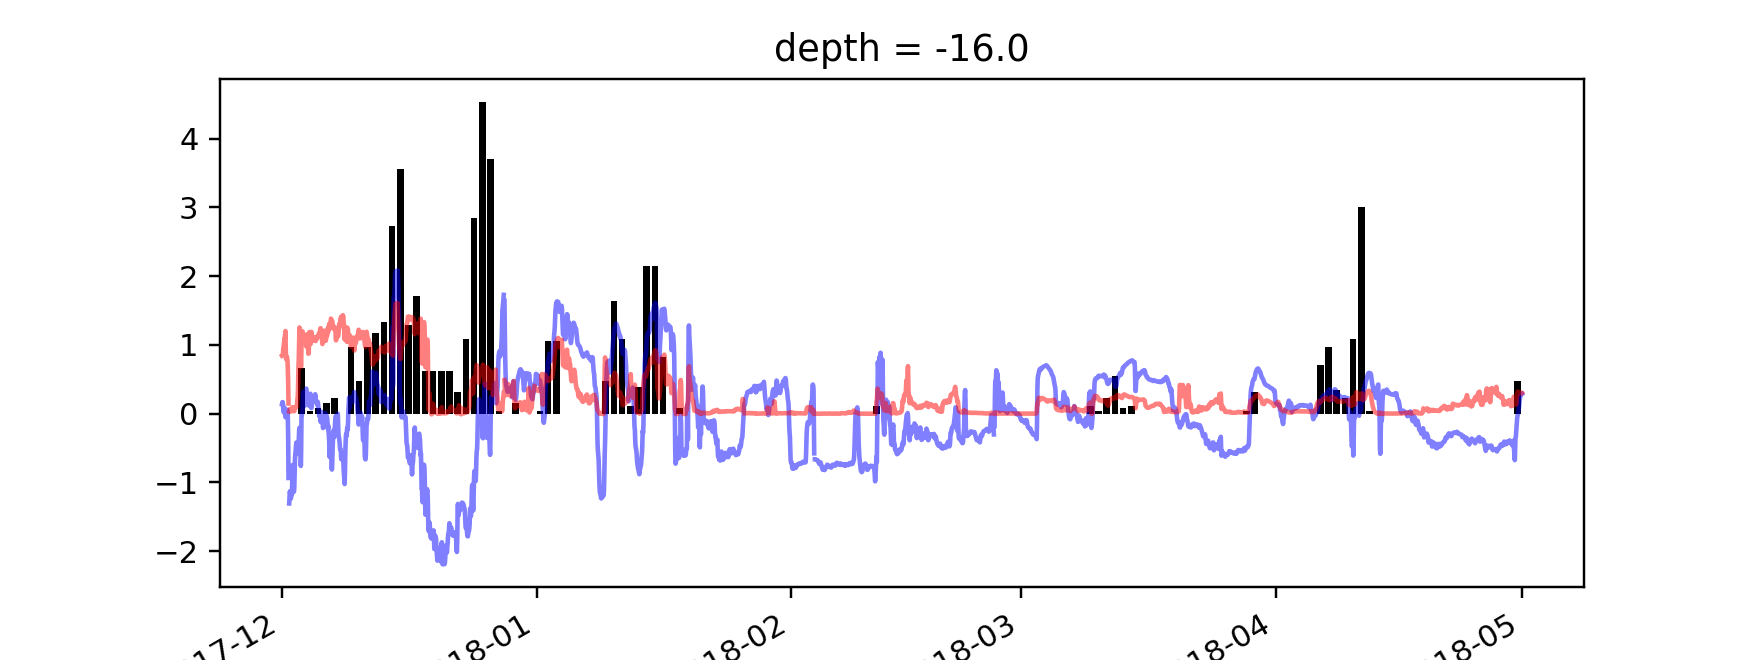

<BarContainer object of 151 artists>

In [1781]:
fig, ax= plt.subplots(figsize=(8,3))
# dSIG.sel(time=slice(datetime(2017,12,1),datetime(2018,4,30,23))).plot()
# (m1t.sig0.mean('depth')-SIG_lp).sel(time=time_range).plot(c='dodgerblue')

# (m1t.sig0.sel(depth=-16)-SIG_sfc_lp).sel(time=time_range).plot(c='b')

(m1t.sig0.sel(depth=-16)-SIG_sfc_lp).sel(time=time_range).plot(c='b',alpha=0.5, label='density')
# (m1t.sig0.sel(depth=-16)-SIG_sfc_mp).sel(time=time_range).plot(c='dodgerblue')
# 
# (m1t.T-m1t.Tf).mean('depth').sel(time=time_range).plot(c='lightcoral')
(m1t.T-m1t.Tf).sel(depth=-16).sel(time=time_range).plot(c='r',alpha=0.5, label='T')

# (2*esei).plot(c='gray')
# (2*eseo).plot(c='dodgerblue')

plt.bar(DS.time, DS.polynya_extent/1000, color='k',align='edge', zorder=-1)

<IPython.core.display.Javascript object>


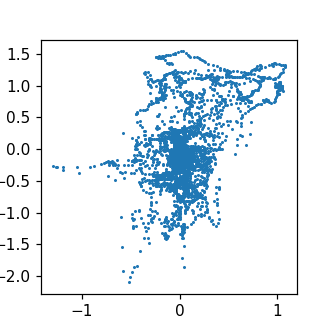

In [1737]:
fig, ax= plt.subplots(figsize=(3,3))

lag = 12
x = eseo[:-lag]
y = (m1t.sig0.sel(depth=-16)-SIG_sfc_lp).sel(time=time_range)[lag:]
ax.scatter(x, y, s=1)

<IPython.core.display.Javascript object>


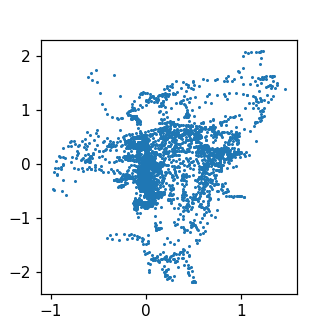

In [1728]:
fig, ax= plt.subplots(figsize=(3,3))

lag = 12
x = eseo[:-lag]
y = (m1t.sig0.sel(depth=-16)-SIG_sfc_lp).sel(time=time_range)[lag:]
ax.scatter(x, y, s=1)

In [1738]:
cst['L_i']

<Quantity(334000.0, 'joule / kilogram')>

# Up-canyon transport across individual years

In [49]:

spec_y_dates = spec_y1
other_y_dates = other_y1
open_years = '2016_2017'

spec_y_dates = spec_y2
other_y_dates = other_y2
open_years = '2017_2018'
    
m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_ocean_currents_{open_years}.nc')
m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_ocean_currents_{open_years}.nc')
m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_ocean_currents_{open_years}.nc')

m1i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc')
m2i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_{open_years}.nc')
m3i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_{open_years}.nc')
m4i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_{open_years}.nc')

m1t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
m2t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
m3t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
m4t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')


NameError: name 'spec_y1' is not defined

NameError: name 'm1' is not defined

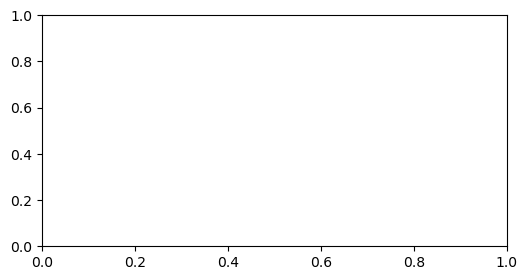

In [50]:
fig, ax = plt.subplots(figsize=(6,3))

# M = 'm3'
# m = m3


x_off = 0

for M, m, mt, x_off in zip(['m1','m2', 'm3', 'm4'], [m1, m2, m3, m4], [m1t,  m2t, m3t, m4t], [0,0.5,1,1.5]):
    
    # .sel(depth=slice(*mvec[M]['depth_range']))
    mtcrop = mt.resample(time="24H").mean()
    dt = mtcrop.T - mtcrop.Tf
    
    mcrop = m.resample(time="24H").mean()
    ucf = vectors.comp_along_theta(mcrop.u, mcrop.v, upslope[M]['angle'])

    for the_dates, color in zip([spec_y_dates, other_y_dates], ['r', 'dodgerblue']):

        over_time = -ucf.sel(time=the_dates)
        
        center = x_off+over_time.mean('time')
        
        ax.plot(center, ucf.depth, c=color, zorder=-1)
        ax.fill_betweenx( ucf.depth,
                         center-0.5*over_time.std('time'),
                        center+0.5*over_time.std('time'),
                         color=color,alpha=0.25, lw=0, zorder=-1)
        
#         ax.plot(x_off+over_time.mean('time')+0.5*over_time.std('time'), ucf.depth, c=color, lw=0.5)
#         ax.plot(x_off+over_time.mean('time')-0.5*over_time.std('time'), ucf.depth, c=color, lw=0.5)
        
        
        over_time2 = dt.sel(time=the_dates)
        x2 = 0.1
        if color =='r':
            x2 = -0.1
            
        DT = over_time2.mean('time')
        ax.scatter(np.zeros(len(dt.depth))+x_off+x2, dt.depth, facecolor=cmocean.cm.thermal(DT/2),
                   edgecolor=color, s=20, lw=0.5)
        
        DT = over_time2.mean('time') + 0.5*over_time2.std('time')
        ax.scatter(np.zeros(len(dt.depth))+x_off+x2+0.05, dt.depth, facecolor=cmocean.cm.thermal(DT/2),
                   edgecolor=color, s=10, lw=0.5)
        
        
        DT = over_time2.mean('time') - 0.5*over_time2.std('time')
        ax.scatter(np.zeros(len(dt.depth))+x_off+x2-0.05, dt.depth, facecolor=cmocean.cm.thermal(DT/2),
                   edgecolor=color, s=10, lw=0.5)
        
#         ax.plot(x_off+over_time.mean('time'), ucf.depth, c=color)

    ax.axvline(x_off, c='k', lw=0.5, zorder=-1)

# fig.savefig(f'/Users/mackenziejewell/Desktop/depth_composites_{open_years}.png', dpi=300, bbox_inches='tight')

In [1574]:
open_thresh=10
RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
    
map_spec_sic = {}

for group, dates in zip (['open', 'comp'],[all_spec_dates, all_other_dates]):

    print(group)
    map_spec_sic[group] = unisic.calc_meansic_openfreq(pd.to_datetime(dates), crop=crop, 
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

open
comp


In [1626]:
cdata

{'tip_x': array([47140.7517705 , 46719.9960228 , 45848.75366538, ...,
        19568.50809858, 20645.68271748, 22116.47908163]),
 'tip_y': array([-2223409.75236302, -2223570.67143258, -2223174.45609865, ...,
        -2237700.1664326 , -2237768.36911793, -2237619.37255474]),
 'vec_x': array([   261.40465451,   -159.35109319,  -1030.59345061, ...,
        -27486.19270129, -26409.01808239, -24938.22171823]),
 'vec_y': array([  3079.98408271,   2919.06501315,   3315.28034709, ...,
        -11191.13506502, -11259.33775035, -11110.34118716]),
 'itip_x': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        na

In [1104]:
# all_spec_dates = np.array([], dtype=np.datetime64)
# # for ss in range(88,95+1):
# for ss in range(96,106+1):

#     all_spec_dates = np.append(all_spec_dates, all_seqs[ss])
    
# print(all_spec_dates[0], all_spec_dates[-1])

2017-12-03 00:00:00 2018-04-30 00:00:00


<IPython.core.display.Javascript object>


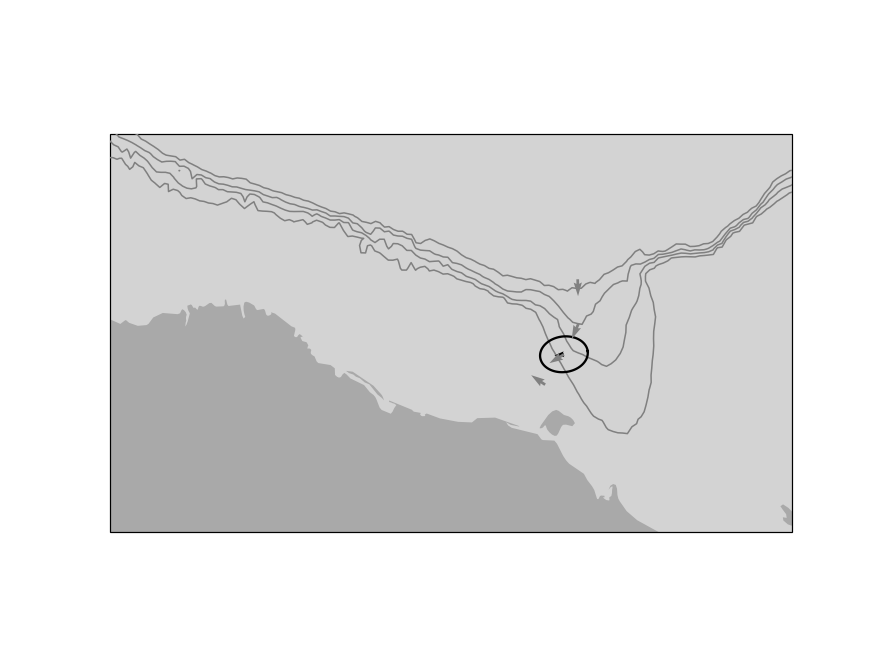

In [1617]:
fig, ax = fn.makemap(view='reallyzoom', contours = [-400,-300,-200,-100])

ax.scatter(tip_xx, tip_yy, s=1)
ax.quiver(tail_xx, tail_yy, np.nanmean(xp), np.nanmean(yp), 
          angles='xy', scale_units='xy', scale=1, color='k',width = aw, zorder=100)


ax.plot(varell['xe']+tail_xx, varell['ye']+tail_yy, c='k', zorder=100)

# geomap.gebco_bathymetry(ax,
#                  crop_lat=(69, 72.5), crop_lon=(-170, -130), clat=2, clon=5, depth_shade=True, 
#                  shade_norm=mpl.colors.TwoSlopeNorm(vmin=-500,vcenter=-400,vmax=-300,), 
#                         shade_cmap = cmocean.cm.haline,
# #                  shade_cmap=mpl.colors.LinearSegmentedColormap object at 0x138ecb3b0>, 
#                  shade_zorder=0, depth_contours=True, contour_levels=[-400,-350,-325,-300,-275,-250,-200, -150,-100, -20], 
#                  contour_kwargs={'colors': 'gray', 'linewidths': 1, 'linestyles': 'dashed', 'zorder': 1},
#                  contour_labels=True, text_kwargs={'size': 10, 'color': 'gray', 'weight': 'normal', 'zorder': 100})


for M in upslope.keys():

    ax.quiver(*upslope[M]['tail'], *upslope[M]['vec'], 
              angles='xy', scale_units='xy', scale=1, color='gray',width = aw, zorder=100)


<IPython.core.display.Javascript object>


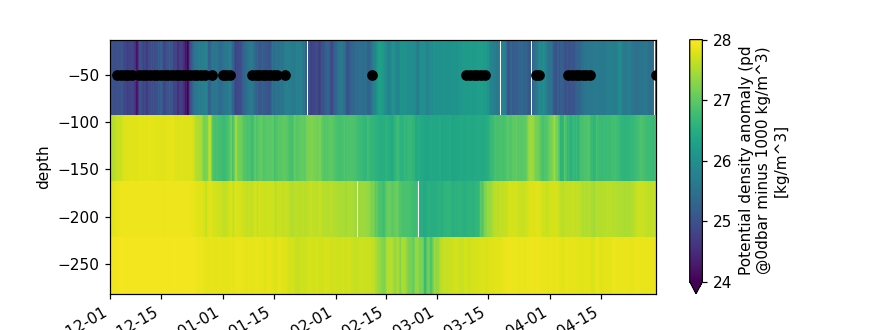

In [1326]:
fig, ax = plt.subplots(figsize=(8,3))
# (m3t.T-m3t.Tf).sel(time=slice(datetime(2016,12,1),datetime(2017,5,1))).plot(vmin=0, vmax=2)

(m3t.sig0).sel(time=time_range).plot(vmin=24, vmax=28)

ax.scatter(all_spec_dates, np.zeros(len(all_spec_dates))-50, c='k')

<IPython.core.display.Javascript object>


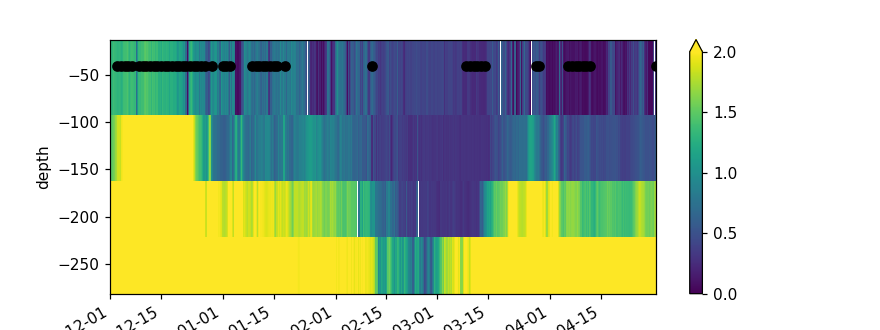

In [1000]:
fig, ax = plt.subplots(figsize=(8,3))
# (m3t.T-m3t.Tf).sel(time=slice(datetime(2016,12,1),datetime(2017,5,1))).plot(vmin=0, vmax=2)

(m3t.T-m3t.Tf).sel(time=time_range).plot(vmin=0, vmax=2)
ax.scatter(all_spec_dates, np.zeros(len(all_spec_dates))-40, c='k')

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))

In [1235]:
# SIG = (m2t.sig0).sel(depth=slice(-120,-0)).mean('depth')

# SIG = (m2t.sig0).mean('depth')


# time_range = slice(datetime(2016,12,1),datetime(2017,4,30))

time_range = slice(datetime(2017,12,1),datetime(2018,4,30))


Mt = m3t
Mo = m3
Mi = m3i

times = Mt.sel(time=time_range).time[::6]
# SIG = (Mt.sig0).sel(depth=slice(-60,-0)).mean('depth').resample(time="6H").mean()

SIG = (Mt.sig0).sel(depth=slice(-180,-150)).mean('depth').resample(time="6H").mean()

# SIG = (m1t.sig0).sel(depth=slice(-120,-0)).mean('depth')

SIG_lp = tseries.running_mean(SIG, length=4*30, center=True, address_nans=True)
dSIG = SIG-SIG_lp


ui = Mi.sel(depth=0).u
vi = Mi.sel(depth=0).v

speed = np.sqrt(ui**2+vi**2)
ese = vectors.comp_along_theta(ui, vi, 145*units('degree'))

ese_sm = ese.resample(time="6H").mean()
speed_sm = speed.resample(time="6H").mean()

/Users/mackenziejewell/Documents/GitHub/SBSpolynya/notebooks/../../timeseries/adjust.py:154: RuntimeWarning: Mean of empty slice
  running_mean[ii] = np.nanmean(variable[ii-length:ii+length+1])


<IPython.core.display.Javascript object>


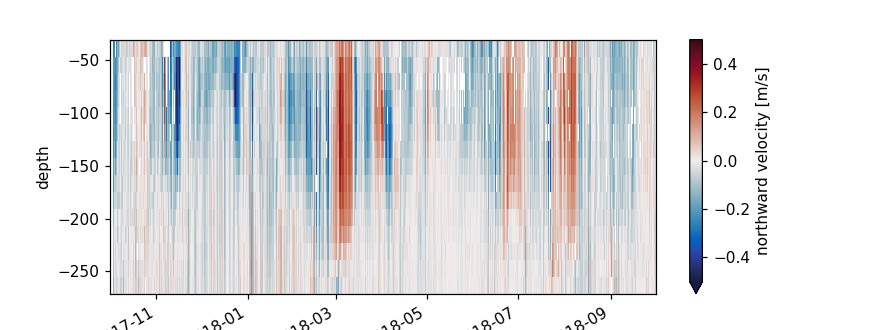

In [1237]:
fig, ax = plt.subplots(figsize=(8,3))
Mo.v.plot(vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance)#.mean('depth')

In [1243]:
uo = Mo.u
vo = Mo.v

upslope = vectors.comp_along_theta(uo, vo, -120*units('degree'))


# upslope = SIG = (Mt.sig0).sel(depth=slice(-60,-0)).mean('depth').resample(time="6H").mean()

<IPython.core.display.Javascript object>


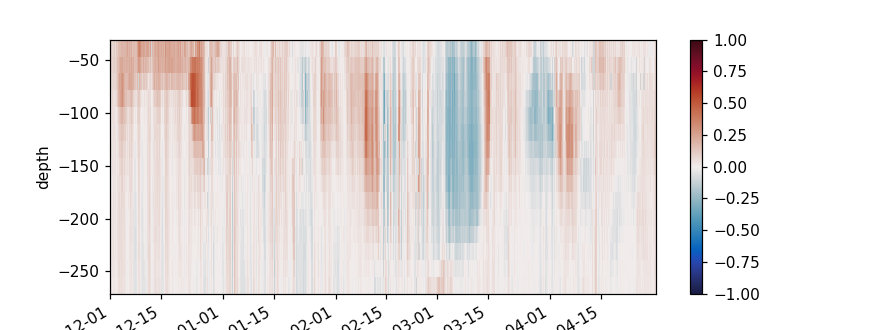

In [1245]:
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')
upslope.sel(time=time_range).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

In [1022]:
%matplotlib notebook

<IPython.core.display.Javascript object>


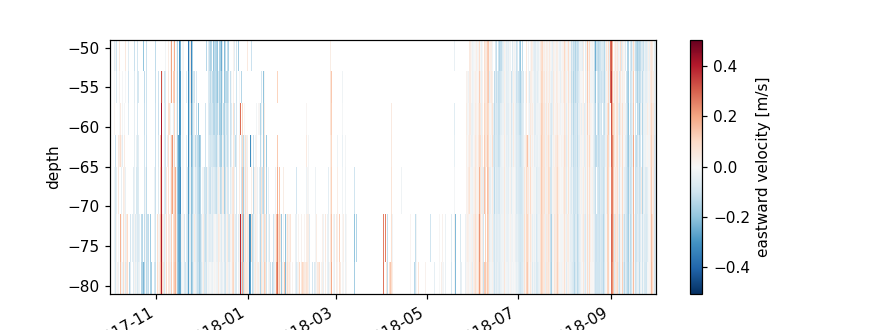

In [1119]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(m2t.sel(time=time_range).time, SIG_lp.sel(time=time_range))
plt.plot(times, dSIG.sel(time=time_range))
plt.plot(times, ese_sm.sel(time=time_range))
# ax.scatter(all_spec_dates, np.zeros(len(all_spec_dates)), c='k')

<IPython.core.display.Javascript object>


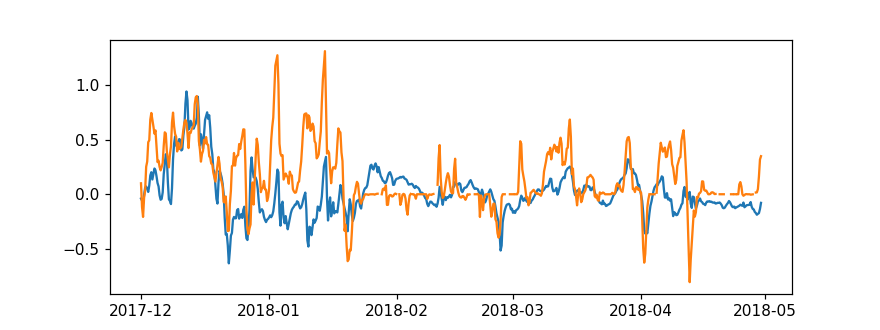

In [1114]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(m2t.sel(time=time_range).time, SIG_lp.sel(time=time_range))
plt.plot(times, dSIG.sel(time=time_range))
plt.plot(times, ese_sm.sel(time=time_range))

In [1056]:
from scipy import stats

In [1115]:
dates_only = np.array([datet-timedelta(hours=datet.hour) for datet in pd.to_datetime(ese_sm.sel(time=time_range).time.values)])
flags = [True if date in all_spec_dates else False for date in dates_only]     


<IPython.core.display.Javascript object>


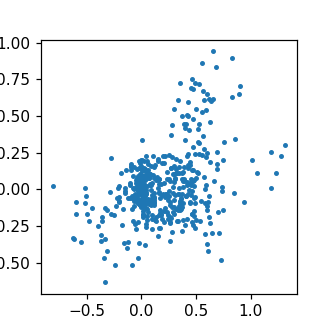

LinregressResult(slope=0.3064801986184758, intercept=-0.035743651104322045, rvalue=0.40475067133325376, pvalue=5.923417297774894e-20, stderr=0.032006707238044094, intercept_stderr=0.011671921462795425)

In [1117]:
fig, ax = plt.subplots(figsize=(3,3))

lag = 1
cond = speed_sm.sel(time=time_range)>0.01
x = ese_sm.sel(time=time_range)[cond].values#[:-lag]
y = dSIG.sel(time=time_range)[cond].values#[lag:]

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

ax.scatter(x_nn, y_nn, s=5)


# ax.scatter(ese_sm.sel(time=time_range)[flags], dSIG.sel(time=time_range)[flags], s=5, c='r')


res = stats.linregress(x_nn, y_nn)
res



<IPython.core.display.Javascript object>


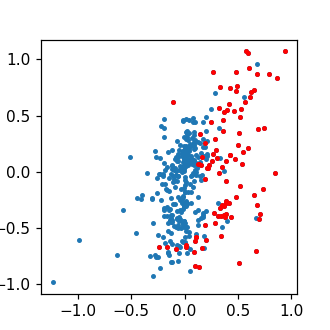

LinregressResult(slope=0.6432945513170815, intercept=-0.1109038749524009, rvalue=0.4172193844332136, pvalue=6.562459849915946e-19, stderr=0.06895114143824971, intercept_stderr=0.01835675629416145)

In [1102]:
fig, ax = plt.subplots(figsize=(3,3))

lag = 1
cond = speed_sm.sel(time=time_range)>0.01
x = ese_sm.sel(time=time_range)[cond].values#[:-lag]
y = dSIG.sel(time=time_range)[cond].values#[lag:]

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

ax.scatter(x_nn, y_nn, s=5)


ax.scatter(ese_sm.sel(time=time_range)[flags], dSIG.sel(time=time_range)[flags], s=5, c='r')


res = stats.linregress(x_nn, y_nn)
res


# res.rvalue**2


# ax.set_xlim(-1,1.5)

<IPython.core.display.Javascript object>


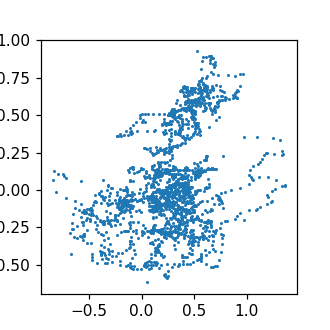

In [999]:
fig, ax = plt.subplots(figsize=(3,3))

lag = 1
ax.scatter(ese[speed>0.1][:-lag], 
           (SIG.sel(time=time_range) - SIG_lp.sel(time=time_range))[speed>0.1][lag:], s=1)
# ax.set_xlim(-1,1.5)

<IPython.core.display.Javascript object>


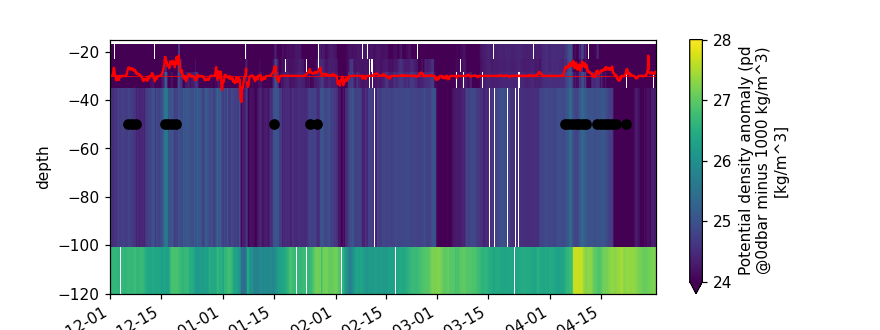

(-120.0, -15.0)

In [1006]:
fig, ax = plt.subplots(figsize=(8,3))
# (m3t.T-m3t.Tf).sel(time=slice(datetime(2016,12,1),datetime(2017,5,1))).plot(vmin=0, vmax=2)


# time_range = slice(datetime(2017,12,1),datetime(2018,4,30))





(m2t.sig0).sel(time=time_range).plot(vmin=24, vmax=28)
ax.scatter(all_spec_dates, np.zeros(len(all_spec_dates))-50, c='k')
ax.plot(m2t.sel(time=time_range).time, 8*(ese) - 30, c='r')
ax.axhline(-30, lw=0.5, c='r')
plt.ylim(-120,-15)

<IPython.core.display.Javascript object>


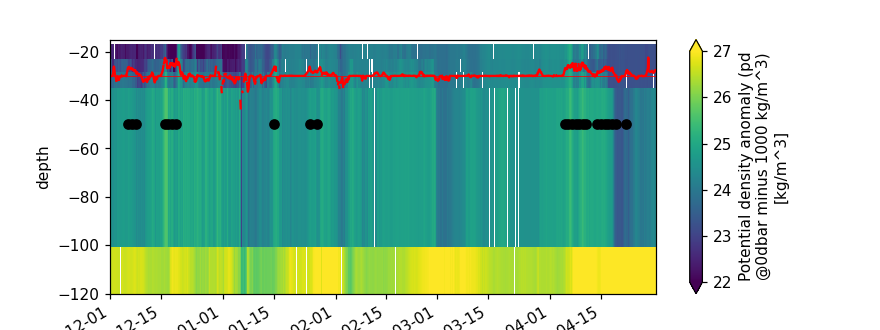

(-120.0, -15.0)

In [900]:
fig, ax = plt.subplots(figsize=(8,3))
# (m3t.T-m3t.Tf).sel(time=slice(datetime(2016,12,1),datetime(2017,5,1))).plot(vmin=0, vmax=2)


time_range = slice(datetime(2017,12,1),datetime(2018,4,30))


ese = vectors.comp_along_theta(m2i.sel(depth=0).u.sel(time=time_range).values, 
                               m3i.sel(depth=0).v.sel(time=time_range).values, 145*units('degree'))

(m2t.sig0).sel(time=time_range).plot(vmin=22, vmax=27)
ax.scatter(all_spec_dates, np.zeros(len(all_spec_dates))-50, c='k')
ax.plot(m2t.sel(time=time_range).time, 8*(ese) - 30, c='r')
ax.axhline(-30, lw=0.5, c='r')
plt.ylim(-120,-15)

In [785]:
xo = np.nanmean(xp)
yo = np.nanmean(yp)

In [594]:
0.05*units('m/s').to('km/day')

<Quantity(4.32, 'kilometer / day')>

In [448]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


for m in [m1i, m2i, m3i, m4i]:
    tail, tip, vec = grab_ice_vector(m, date)

In [478]:

for date in pd.date_range(datetime(2017,12,1), datetime(2018,4,30)):

    # open sic
    #------------
    RES = '3125'
    crop=[1500, 2050, 480, 700]
    sic_key = 'sic'
    sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                 crop=crop, coordinates=False, area=False, include_units=False, quiet=True)



    fig, ax = fn.makemap(view='reallyzoom', contours = [-500, -200,-100])

    ax.set_title(date.strftime("%Y-%m-%d"))

    ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])


    aw = 0.004

    for m, mt, n in zip([m1, m2, m3, m4], [m1t, m2t, m3t, m4t], [1,2,3,4]):
                     
        if n == 1:
            C2 = 'k'
        else:
            props = grab_props(mt, date, depth_range = (-500,-150))
            C2 = cmocean.cm.thermal(props['dT']/1.5)
        
        props = grab_props(mt, date, depth_range = (-150,0))
        C = cmocean.cm.thermal(props['dT']/1.5)
        ax.scatter(m.attrs['lon'], m.attrs['lat'], s=50, color=C, edgecolor=C2,transform=ccrs.PlateCarree())

    tail, tip, vec = grab_vector(m1, date, depth_range = (-150,0))
    ax.quiver(*tail, *vec, angles='xy', scale_units='xy', scale=1, color='r',width = aw, zorder=100)



    for m in [m2, m3, m4]:
        tail, tip, vec = grab_vector(m, date, depth_range = (-500,-150))
        ax.quiver(*tail, *vec, angles='xy', scale_units='xy', scale=1, color='darkorange',width = aw, zorder=100)
    
    for m in [m2, m3, m4]:
        tail, tip, vec = grab_vector(m, date, depth_range = (-150,0))
        ax.quiver(*tail, *vec, angles='xy', scale_units='xy', scale=1, color='r',width = aw, zorder=100)

        
    for m in [m1i, m2i, m3i, m4i]:
        tail, tip, vec = grab_ice_vector(m, date)
        ax.quiver(*tail, *vec, angles='xy', scale_units='xy', scale=1, color='k',width = 0.75*aw, zorder=100)
    
    
    
    
    

    fig.savefig(f'/Users/mackenziejewell/Desktop/MARES_current_maps/map_{date.strftime("%Y-%m-%d")}.png',
               dpi =300, bbox_inches='tight')

    plt.clf()
    fig.clear()

/Users/mackenziejewell/Documents/GitHub/SBSpolynya/notebooks/../functions.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=figsize)


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [63]:
def grab_icevector_range(ds, dates, daily_means = False):
        
        
    tails = []
    tips = []
    vecs = []
    
    for date in dates:
        
        if daily_means:
            dsc = ds.sel(time = slice(date, date+timedelta(hours=23))).resample(time='1D').mean('time')
            
        else:
            
            dsc = ds.sel(time = slice(date, date+timedelta(hours=23)))

        # daily mean vector components
        U = dsc.u.sel(depth = 0).values
        V = dsc.v.sel(depth = 0).values


        map_proj = ccrs.NorthPolarStereo(central_longitude=-140)



        for u, v in zip(U, V):
            tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                             eastward = u*units('m/s'), northward = v*units('m/s'), 
                                             final_units = 'm/day')

            tails.append(tail)
            tips.append(tip)
            vecs.append(vec)

    return tails, tips, vecs

def grab_vector_range(ds, dates, depth_range = (-150,0), daily_means = False):
        
        
    tails = []
    tips = []
    vecs = []
    
    for date in dates:
        
        
        if daily_means:
            dsc = ds.sel(time = slice(date, date+timedelta(hours=23))).resample(time='1D').mean('time')
            
        else:
            dsc = ds.sel(time = slice(date, date+timedelta(hours=23)))

        # daily mean vector components
        U = dsc.u.sel(depth = dsc.depth[(dsc.depth>depth_range[0]) & (dsc.depth<depth_range[1])]).mean('depth').values
        V = dsc.v.sel(depth = dsc.depth[(dsc.depth>depth_range[0]) & (dsc.depth<depth_range[1])]).mean('depth').values


        map_proj = ccrs.NorthPolarStereo(central_longitude=-140)



        for u, v in zip(U, V):
            tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                             eastward = u*units('m/s'), northward = v*units('m/s'), 
                                             final_units = 'm/day')

            tails.append(tail)
            tips.append(tip)
            vecs.append(vec)

    return tails, tips, vecs


In [64]:
def grab_ice_vector(ds, date):
        
    dsc = ds.sel(time = slice(date, date+timedelta(hours=23))).mean('time')

    # daily mean vector components
    U = dsc.u.values
    V = dsc.v.values
    
    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                     eastward = U*units('m/s'), northward = V*units('m/s'), 
                                     final_units = 'm/day')
    
    return tail, tip, vec


def grab_vector(ds, date, depth_range = (-150,0)):
        
    dsc = ds.sel(time = slice(date, date+timedelta(hours=23))).mean('time')

    # daily mean vector components
    U = dsc.u.sel(depth = dsc.depth[(dsc.depth>depth_range[0]) & (dsc.depth<depth_range[1])]).mean('depth').values
    V = dsc.v.sel(depth = dsc.depth[(dsc.depth>depth_range[0]) & (dsc.depth<depth_range[1])]).mean('depth').values
    
    
    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    tail, tip, vec = vectors.project_vectors(map_proj, ds.attrs['lon'], ds.attrs['lat'], 
                                     eastward = U*units('m/s'), northward = V*units('m/s'), 
                                     final_units = 'm/day')
    
    return tail, tip, vec


def grab_props(ds, date, depth_range = (-150,0)):
        
    dsc = ds.sel(time = slice(date, date+timedelta(hours=23))).mean('time')

    # daily mean vector components
    dT = (dsc.T-dsc.Tf).sel(depth = dsc.depth[(dsc.depth>depth_range[0]) & (dsc.depth<depth_range[1])]).mean('depth').values
    
    props = {}
    props['dT'] = dT
    
    return props


(0.47467950679335086, 0.29601728599654775, 0.5684772490345112, 1.0)

In [466]:
props = grab_props(m1t, date, depth_range = (-150,0))

In [393]:
tail, tip, vec

((432516.9891155934, -2224858.232276175),
 (427592.94878564007, -2231815.105380911),
 (<Quantity([-4924.04032995], 'meter / day')>,
  <Quantity([-6956.87310474], 'meter / day')>))

In [383]:
help(geomap)

Help on module plot_simply.geomap in plot_simply:

NAME
    plot_simply.geomap - # Functions for plotting geographic data

FUNCTIONS
    add_date(fig, ax, dt_obj, date_format='%b %d, %Y (%H:%M UTC)', method='anchor', boxstyle='round,pad=0.,rounding_size=0.2', facecolor='black', edgecolor='black', zorder=10, anchor_loc=4, anchor_prop={'size': 20, 'color': 'white'}, x=0.02, y=0.05, textcolor='white', fontsize=15)
        Add date label to cartopy plot.

        INPUT:
        - fig: cartopy figure
        - ax: cartopy figure axis
        - dt_obj: datetime object of date for plotted data
                    OR
                  string with text to show (date format already provided (e.g. 'Dec 20, 2018 (6:00 UTC)')

        IF dt_obj IS DATETIME OBJECT:
        - date_format: str, format to display date (default: '%b %d, %Y (%H:%M UTC)')
            - example 1: '%b %d, %Y (%H:%M UTC)' could give 'Dec 20, 2018 (6:00 UTC)'
            - example 2: '%m-%d-%Y' could give '12-20-2018'

     

In [381]:
m2u

<xarray.DataArray 'u' ()>
array(-0.06912942)

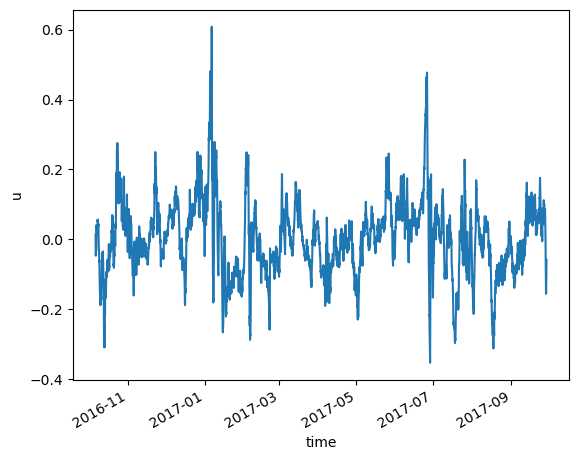

In [372]:
m2.sel(depth = m2.depth[m2.depth>-150]).mean('depth').u.plot()

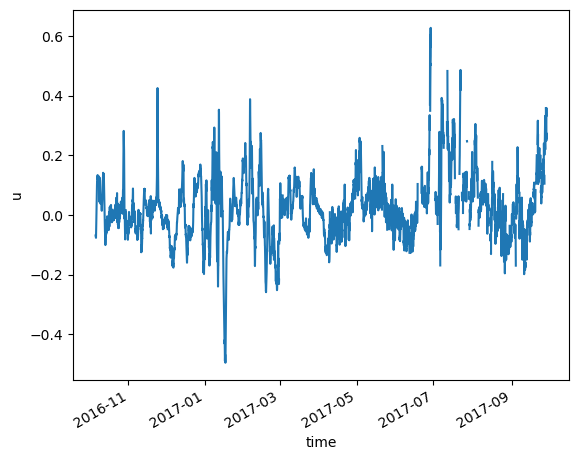

In [371]:
m3.sel(depth = m3.depth[m3.depth>-150]).mean('depth').u.plot()

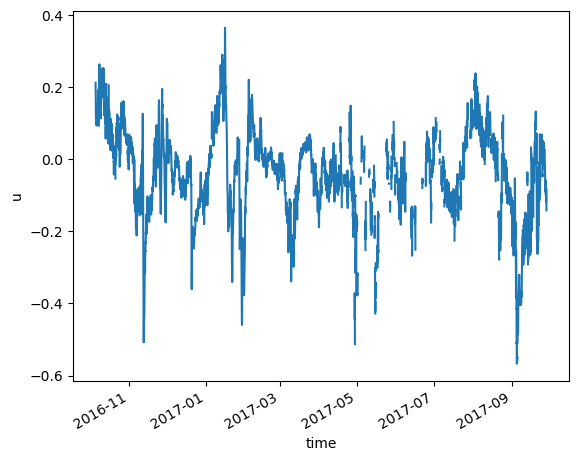

In [370]:
m4.sel(depth = m4.depth[m4.depth>-150]).mean('depth').u.plot()

In [ ]:
m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_2016_2017.nc')
